In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import math

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, LSTM, Bidirectional, Dropout, Concatenate
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import keras.backend as K

2024-06-22 00:18:46.519790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 00:18:47.057764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-22 00:18:47.057794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-22 00:18:47.144582: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 00:18:48.686094: W tensorflow/stream_executor/platform/de

In [3]:
from numpy.lib.stride_tricks import sliding_window_view

In [4]:
import tensorflow as tf

In [5]:
from IPython.display import clear_output

In [6]:
import re

## Import data and transform to dataframe

In [19]:
info = pd.DataFrame({})

In [20]:
# Load CSV with the metadata of each sensor file

for folder_distance in ['tutorial_6cm','tutorial_9cm','tutorial_12cm','tutorial_16cm','tutorial_20cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info_aux['distance'] = int(re.findall(r'\d+',folder_distance)[0])/100
    info = pd.concat([info, info_aux])

In [21]:
# This function is used mainly to join the original
# bitstream information to each file. It also creates 
# columns for visualization

def add_inputs_labels(df,row,i,injection_time,injection_amount,bit_duration):
    input_name = 'input_' + str(i)
    bitstream_name = 'bitstream_' + str(i)
    
    df[input_name] = 0
    df[bitstream_name] = row[bitstream_name][1:]

    time_add = 0
    for count, bit in enumerate(row[bitstream_name][1:].split()[0]):
        df.loc[(df.sim_time <= injection_time + time_add) & (df.sim_time >= time_add),input_name] = injection_amount*int(bit)
        time_add += bit_duration
    return df

In [22]:
# Load data from each sensor csv into a dataframe dictionary

data = {}

for index,row in info.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::10].reset_index(drop=True)
    for i in range(0,1):
        add_inputs_labels(data_aux,row,i,0.1,400,1)
    data_aux['distance'] = row['distance']
    data.update({index: data_aux})


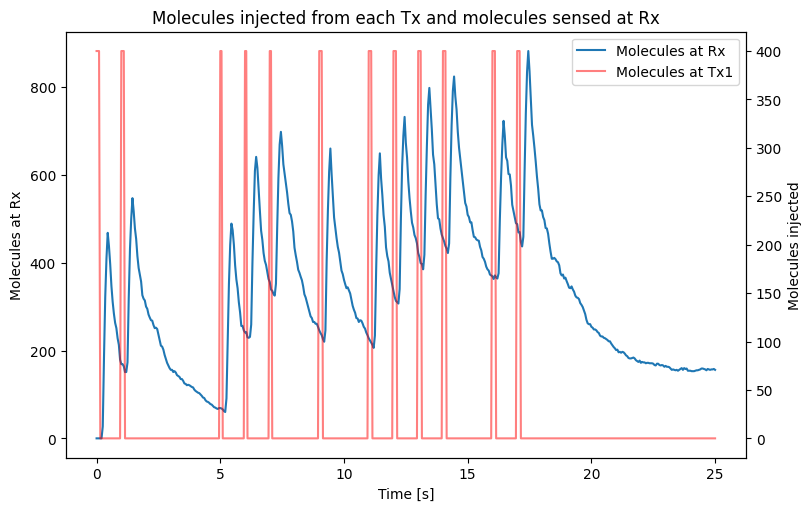

In [23]:
#Visualize each dataset
chosen_dataset = 12

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
#y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
#sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
fig.savefig("single_source_ml.png", dpi=300)

## Data Augmentation and train/test split

In [24]:
# Create the input and output matrix
    
x_all = np.zeros((len(data),data[0]['molecule_count'].size))
y_all = np.zeros((len(data),1))
y_all_bitstream = np.zeros((len(data),len([int(i) for i in data[0]['bitstream_0'][0]])))

for i in range(0,len(data)):
    x_all[i] = data[i]['molecule_count']
    y_all[i] = [data[i]['distance'][0]]
    y_all_bitstream[i] = [int(i) for i in data[i]['bitstream_0'][0]]


## Data training

In [64]:
from scipy.optimize import minimize

data_rate = 1
N_tx = 2500
v_eff = 0.09 # m/s
rx_length = 0.01

model_chosen = 1

sequence = y_all_bitstream[model_chosen]
x_first_test = x_all[model_chosen]

t_i = np.arange(0,25,0.05)


def ob_prob(d,v_eff,rx_length,t):
    t_1 = (d-rx_length/2)/(2*v_eff)
    t_2 = (d+rx_length/2)/(2*v_eff)
    
    #print("Distance between source and receiver is: " + str(d[0]) + " m")
    
    if t>=t_1 and t<=t_2:
        return 1 - (d-rx_length/2)/(2*v_eff*t)
    if t > t_2:
        return rx_length/(2*v_eff*t)
    else: 
        return 0


def mean_mol_number(N_tx,d,sequence,v_eff,t):
    aux = 0
    
    for i in range(0,len(sequence)):
        aux = aux + sequence[i]*ob_prob(d,v_eff,rx_length,t-i*data_rate)
        
    if aux > 0:
        return N_tx*aux
    else:
        return 0.000001
    

def neg_log_likelihood(d,x,sequence,v_eff):
    
    log_likelihood = 0
    
    #print("Distance between source and receiver is: " + str(d[0]) + " m")
    
    for i in range(0,len(t_i)):
        log_likelihood = log_likelihood + x[i]*math.log(mean_mol_number(N_tx,d,sequence,v_eff,t_i[i])) - mean_mol_number(N_tx,d,sequence,v_eff,t_i[i])
    
    return -log_likelihood

# def negative_log_likelihood_jac(d,x_first_test):
#     x = x_first_test
    
#     residuals = x - d
#     jac = -np.sum(residuals)
    
#     return jac


# Initial d_tx guess
initial_params = [0.12]

# Use the L-BFGS-B optimization method to maximize the Poisson likelihood
result = minimize(neg_log_likelihood, initial_params, args=(x_first_test,sequence,v_eff), method='Nelder-Mead')

# Extract the optimized parameter
optimized_rate = result.x[0]

print("Optimized Distance:", optimized_rate)
print("Actual Distance:", data[model_chosen]['distance'][0])

Optimized Distance: 0.15448242187500003
Actual Distance: 0.16


In [65]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -248597.28773768572
             x: [ 1.545e-01]
           nit: 15
          nfev: 30
 final_simplex: (array([[ 1.545e-01],
                       [ 1.545e-01]]), array([-2.486e+05, -2.486e+05]))

In [66]:
from scipy.stats import poisson

In [71]:
data_rate = 1
N_tx = 3200
v_eff = 0.075 # m/s
rx_length = 0.01

model_chosen = 5

sequence = y_all_bitstream[model_chosen]
x_first_test = x_all[model_chosen]

t_i = np.arange(0,25,0.05)

d = 0.12

n_exp_mol = [poisson.rvs(mean_mol_number(N_tx,d,sequence,v_eff,i),1) for i in t_i]


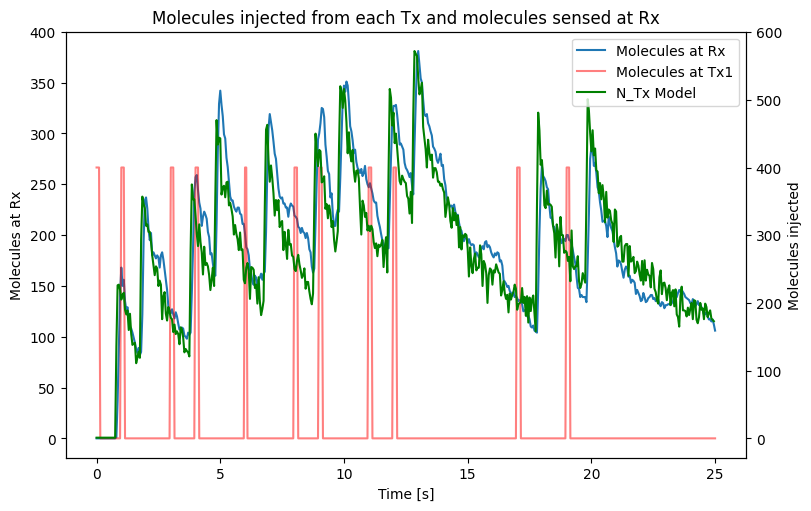

In [72]:
#Visualize each dataset
chosen_dataset = 5

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
plt.plot(t_i,n_exp_mol,color='green', label = "N_Tx Model")

plt.title("Molecules injected from each Tx and molecules sensed at Rx")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
#fig.savefig("two_sources_10_2.png", dpi=300)

In [59]:
ml_result_table = np.zeros([y_all.shape[0],2])

In [60]:
ml_result_table.shape

(499, 2)

In [73]:
# Initial d_tx guess
initial_params = [0.12]

v_eff = 0.0775 # m/s

for i in range(0,len(data)):
    
    print(i)

    sequence = y_all_bitstream[i]

    result = minimize(neg_log_likelihood, initial_params, args=(x_all[i],sequence,v_eff), method='Nelder-Mead')

    ml_result_table[i] = [data[i]['distance'][0], result.x[0]]
    print(ml_result_table[i])
    



0
[0.12       0.10292578]
1
[0.16      0.1361792]
2


/tmp/ipykernel_37205/343233520.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  return rx_length/(2*v_eff*t)
/tmp/ipykernel_37205/343233520.py:34: RuntimeWarning: invalid value encountered in double_scalars
  aux = aux + sequence[i]*ob_prob(d,v_eff,rx_length,t-i*data_rate)
/tmp/ipykernel_37205/343233520.py:49: RuntimeWarning: invalid value encountered in double_scalars
  log_likelihood = log_likelihood + x[i]*math.log(mean_mol_number(N_tx,d,sequence,v_eff,t_i[i])) - mean_mol_number(N_tx,d,sequence,v_eff,t_i[i])


[0.06       0.05006104]
3
[0.06       0.05021118]
4
[0.2        0.15916699]
5
[0.16       0.14314453]
6
[0.2        0.15914502]
7
[0.09       0.07420605]
8
[0.06      0.0502522]
9
[0.2   0.159]
10
[0.16       0.13639307]
11
[0.16       0.14340088]
12
[0.06       0.05028662]
13
[0.12       0.10296387]
14
[0.12       0.10443164]
15
[0.12       0.10442285]
16
[0.09       0.07436206]
17
[0.2       0.1589458]
18
[0.16       0.13645166]
19
[0.09       0.07426318]
20
[0.2       0.1588623]
21
[0.2        0.15898828]
22
[0.09       0.07411523]
23
[0.2       0.1591333]
24
[0.12       0.10287598]
25
[0.16       0.13621069]
26
[0.09       0.07432397]
27
[0.12       0.10430566]
28
[0.06       0.05012109]
29
[0.16       0.13645239]
30
[0.06       0.05018774]
31
[0.16       0.13625684]
32
[0.12       0.10289941]
33
[0.16       0.14324561]
34
[0.2        0.15885059]
35
[0.06       0.05027783]
36
[0.2        0.15915527]
37
[0.2        0.15909961]
38
[0.06       0.05029395]
39
[0.06    0.05025]
40
[0.06

In [74]:
ml_result_table

array([[0.12      , 0.10292578],
       [0.16      , 0.1361792 ],
       [0.06      , 0.05006104],
       [0.06      , 0.05021118],
       [0.2       , 0.15916699],
       [0.16      , 0.14314453],
       [0.2       , 0.15914502],
       [0.09      , 0.07420605],
       [0.06      , 0.0502522 ],
       [0.2       , 0.159     ],
       [0.16      , 0.13639307],
       [0.16      , 0.14340088],
       [0.06      , 0.05028662],
       [0.12      , 0.10296387],
       [0.12      , 0.10443164],
       [0.12      , 0.10442285],
       [0.09      , 0.07436206],
       [0.2       , 0.1589458 ],
       [0.16      , 0.13645166],
       [0.09      , 0.07426318],
       [0.2       , 0.1588623 ],
       [0.2       , 0.15898828],
       [0.09      , 0.07411523],
       [0.2       , 0.1591333 ],
       [0.12      , 0.10287598],
       [0.16      , 0.13621069],
       [0.09      , 0.07432397],
       [0.12      , 0.10430566],
       [0.06      , 0.05012109],
       [0.16      , 0.13645239],
       [0.

In [75]:
unseen_data_test = pd.DataFrame(ml_result_table, columns = ['d_gt','d_p'])

In [76]:
unseen_data_test['d_dif'] = unseen_data_test['d_gt'] - unseen_data_test['d_p']

In [79]:
unseen_data_test['dif'] = ((unseen_data_test['d_p']-unseen_data_test['d_gt'])**2)**(1/2)/(unseen_data_test['d_gt']**2)**(1/2)

In [77]:
unseen_data_test['class'] = unseen_data_test.apply(lambda x: str(x['d_gt']),axis=1)


In [80]:
unseen_data_test

d_gt       d_p     d_dif class       dif
0    0.12  0.102926  0.017074  0.12  0.142285
1    0.16  0.136179  0.023821  0.16  0.148880
2    0.06  0.050061  0.009939  0.06  0.165649
3    0.06  0.050211  0.009789  0.06  0.163147
4    0.20  0.159167  0.040833   0.2  0.204165
..    ...       ...       ...   ...       ...
494  0.06  0.050186  0.009814  0.06  0.163574
495  0.12  0.102776  0.017224  0.12  0.143530
496  0.12  0.104347  0.015653  0.12  0.130444
497  0.09  0.074309  0.015691  0.09  0.174341
498  0.06  0.050255  0.009745  0.06  0.162415

[499 rows x 5 columns]

In [81]:
classes = unseen_data_test['class'].unique()

In [84]:
# Performance results

class_data = pd.DataFrame()

for i in range(0,len(classes)):
    aux = unseen_data_test[unseen_data_test['class']==unseen_data_test['class'].unique()[i]]
    aux_data = pd.DataFrame(index = [i],data = {"class": [classes[i]],"95_dif": [aux[aux['dif']<=0.05].count()[0]/aux.count()[0]*100]} )
    aux_data['90_dif'] = aux[aux['dif']<=0.1].count()[0]/aux.   count()[0]*100
    aux_data['80_dif'] = aux[aux['dif']<=0.2].count()[0]/aux.count()[0]*100
    aux_data['50_dif'] = aux[aux['dif']<=0.5].count()[0]/aux.count()[0]*100
    aux_data['MAE'] = (abs(aux['d_p']-aux['d_gt'])).mean()
    class_data = pd.concat([class_data, aux_data])

In [85]:
class_data


class  95_dif  90_dif  80_dif  50_dif       MAE
0  0.12     0.0     0.0   100.0   100.0  0.016443
1  0.16     0.0     0.0   100.0   100.0  0.022161
2  0.06     0.0     0.0   100.0   100.0  0.009789
3   0.2     0.0     0.0     1.0   100.0  0.040780
4  0.09     0.0     0.0   100.0   100.0  0.015746

In [86]:
class_data.to_csv('ML_test_data_single_tube.csv')